<a href="https://colab.research.google.com/github/catarinatomasr/Project_DLNN_Group17/blob/main/Projecto_DNLL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, Model, Input, layers, initializers, regularizers, optimizers, metrics 

import os
import time
import random 
import zipfile
from zipfile import ZipFile as zip

from shutil import copyfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

#from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score, r2_score, accuracy_score
from sklearn.datasets import make_circles
from sklearn.metrics import classification_report

## Connecting to google drive and unzip training and testing files

In [ ]:
from google.colab import drive


# Mount GDrive into your session
drive.mount('/content/drive')
# Setup connection string towards your folder
path_test = "/content/drive/MyDrive/DLNN/Teste_50classes/gen-one_test/"
t0 = time.time()
path_train = "/content/drive/MyDrive/DLNN/Teste_50classes/gen-one_train/"
t1 = time.time()


#Pokemenon Generation One Test

# Transfer zip dataset to the current virtual machine
copyfile (path_test + 'gen-one_test.zip','gen-one_test.zip')
# Extract files
zip = zipfile.ZipFile('gen-one_test.zip')
zip.extractall()
zip.close()
print("File transfer completed in %0.3f seconds" % (time.time() - t0))

#Pokemenon Generation One Train

# Transfer zip dataset to the current virtual machine
copyfile (path_train + 'gen-one_train.zip','gen-one_train.zip')
# Extract files
zip = zipfile.ZipFile('gen-one_train.zip')
zip.extractall()
zip.close()
print("File transfer completed in %0.3f seconds" % (time.time() - t1))



path = "/content/"
main_folder, training_folder, testing_folder = "/content/", "dataset/", "dataset_test/"
#main_folder, training_folder = "/content/", "dataset/"

Mounted at /content/drive
File transfer completed in 1.876 seconds
File transfer completed in 5.134 seconds


## Show a sample image of a pokemon class and main description characteristics of our dataset (number of images, classes and class distribution)

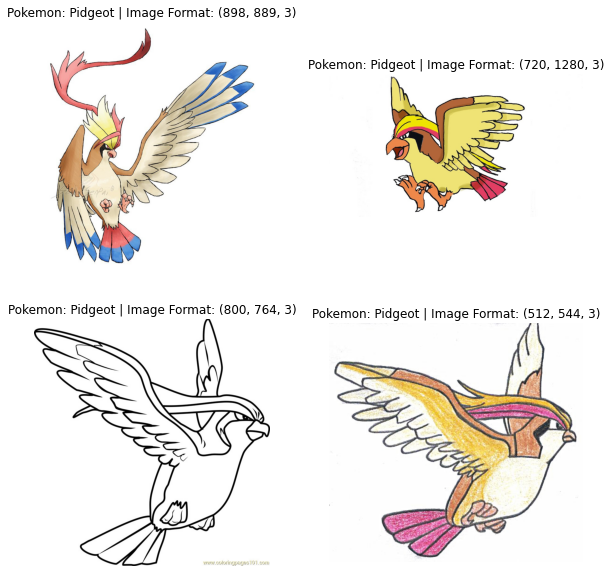

In [ ]:
def show_sample_images(folder_directory, class_):
    # Build a connection string
    full_path = folder_directory + class_ + "/"
    # Get a set of random images
    images = random.sample(os.listdir(full_path), 4)
    # Plot the images
    plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        img = mpimg.imread(full_path + img)
        ax = plt.subplot(2, 2,  i + 1)
        plt.imshow(img)
        plt.title("Pokemon: {} | Image Format: {}".format(class_,img.shape))
        plt.axis("off")

show_sample_images(main_folder + training_folder, 'Pidgeot')

Number of Pokemon classes: 25
Total dataset images: 1374


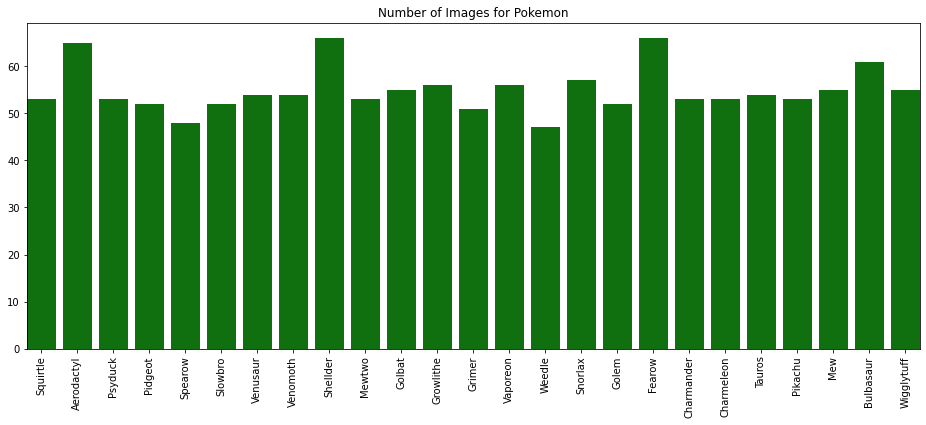

 
Class Distribution:
[('Shellder', 66), ('Fearow', 66), ('Aerodactyl', 65), ('Bulbasaur', 61), ('Snorlax', 57), ('Growlithe', 56), ('Vaporeon', 56), ('Golbat', 55), ('Mew', 55), ('Wigglytuff', 55), ('Venusaur', 54), ('Venomoth', 54), ('Tauros', 54), ('Squirtle', 53), ('Psyduck', 53), ('Mewtwo', 53), ('Charmander', 53), ('Charmeleon', 53), ('Pikachu', 53), ('Pidgeot', 52), ('Slowbro', 52), ('Golem', 52), ('Grimer', 51), ('Spearow', 48), ('Weedle', 47)]


In [ ]:
classes=os.listdir(path + training_folder)
count=0
class_dict = {}
print(f'Number of Pokemon classes: {len(classes)}')
for pokemon in classes:
    poke_path = os.path.join(path + training_folder, pokemon)
    count+=len(os.listdir(poke_path))
    class_dict[pokemon] = len(os.listdir(poke_path))
print(f'Total dataset images: {count}')
fig = plt.figure(figsize = (16, 6))
sns.barplot(x = list(class_dict.keys()), y = list(class_dict.values()), color = 'g').set_title('Number of Images for Pokemon')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()
print(' ')
print('Class Distribution:')
print(sorted(class_dict.items(), key=lambda item: item[1], reverse=True))

In [ ]:
tf.keras.backend.image_data_format()

'channels_last'

### Distribution of train and test datasets:
  - Classes
  - Number of images per class

In [ ]:
for split in [training_folder, testing_folder]:
    for c in classes:
        n_train_c = len(os.listdir(path + split + f"{c}"))
        print(f"Nº of instances of class {c} in the {split}: {n_train_c}")

Nº of instances of class Squirtle in the dataset/: 53
Nº of instances of class Aerodactyl in the dataset/: 65
Nº of instances of class Psyduck in the dataset/: 53
Nº of instances of class Pidgeot in the dataset/: 52
Nº of instances of class Spearow in the dataset/: 48
Nº of instances of class Slowbro in the dataset/: 52
Nº of instances of class Venusaur in the dataset/: 54
Nº of instances of class Venomoth in the dataset/: 54
Nº of instances of class Shellder in the dataset/: 66
Nº of instances of class Mewtwo in the dataset/: 53
Nº of instances of class Golbat in the dataset/: 55
Nº of instances of class Growlithe in the dataset/: 56
Nº of instances of class Grimer in the dataset/: 51
Nº of instances of class Vaporeon in the dataset/: 56
Nº of instances of class Weedle in the dataset/: 47
Nº of instances of class Snorlax in the dataset/: 57
Nº of instances of class Golem in the dataset/: 52
Nº of instances of class Fearow in the dataset/: 66
Nº of instances of class Charmander in the 

### Base parameters for the loading of our training, validation and test datasets

In [ ]:
image_size=(96, 96)
crop_to_aspect_ratio = True
color_mode='rgb'
batch_size=64
label_mode="categorical"
labels = 'inferred'
validation_split=0.2
shuffle=True
seed=0

## Load training and validation dataset with image_dataset_from_directory

In [ ]:
# Training data
ds_train = image_dataset_from_directory(main_folder + training_folder, 
                                        image_size=image_size,
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        labels=labels,
                                        label_mode=label_mode,
                                        subset='training',
                                        validation_split=validation_split, 
                                        shuffle=shuffle,
                                        seed=seed)
# Validation data
ds_val = image_dataset_from_directory(main_folder + training_folder, 
                                      image_size=image_size,
                                      crop_to_aspect_ratio=crop_to_aspect_ratio,
                                      color_mode=color_mode,
                                      batch_size=batch_size,
                                      labels=labels,
                                      label_mode=label_mode,
                                      subset='validation',
                                      validation_split=validation_split, 
                                      shuffle=shuffle,
                                      seed=seed)
# Testing data
ds_test = image_dataset_from_directory(main_folder + testing_folder, 
                                       image_size=image_size,
                                       crop_to_aspect_ratio=crop_to_aspect_ratio,
                                       color_mode=color_mode,
                                       batch_size=batch_size,
                                       label_mode=label_mode,                                     
                                       shuffle=shuffle,
                                       seed=seed)

Found 1372 files belonging to 25 classes.
Using 1098 files for training.
Found 1372 files belonging to 25 classes.
Using 274 files for validation.
Found 311 files belonging to 25 classes.


### Formats of train and validation batches

In [ ]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
#print("\nSample of y_train:", batch_y_train[0:5])
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))

(64, 96, 96, 3) (64, 25)
Sample average of y_train: tf.Tensor(0.04, shape=(), dtype=float32)


In [ ]:
iter_val = iter(ds_val)
batch_x_val, batch_y_val = iter_val.next()
print(batch_x_val.shape, batch_y_val.shape)
#print("\nSample of y_val:", batch_y_val[0:5])
print("Sample average of y_val:", tf.reduce_mean(batch_y_val))

(64, 96, 96, 3) (64, 25)
Sample average of y_val: tf.Tensor(0.04, shape=(), dtype=float32)


## Preprocessing of our dataset

### Rescaling, ReSizing and Cropping
Above we already performed a resizing step in image_dataset_from_directory, so no resizing or cropping is required here.

### Rescaling step
Rescales the values of a batch of images to a given range (aka min-max scaler)

**(in the next steps we will user BatchNormalization to perform this preprocessing step)**

In [ ]:
preprocessing = layers.Rescaling(1./255)

### Data Augmentation
Technique that allows to increase the level of diversity of the training data by means of randomized transformations.

In [ ]:
augmentation = Sequential([layers.RandomFlip(seed=seed), 
                           layers.RandomRotation(0.1, seed=seed), 
                           layers.RandomZoom(0.1, seed=seed),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="augmentation")

## Prediction Model training and validation

### CNN1
Simple architecture, 
  - input layer Conv2D with 64 filters and size 3x3
  - activation function ReLu
  - hidden layer Conv2D with 128 filter and size 3x3
  - activation function ReLu
  - Dense layer with 25 units and activation 'softmax'

without augmentation, batch normalization or Max Pooling 

In [ ]:
input_shape = batch_x_train.shape
cnn1 = Sequential([layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=25, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn1.build(input_shape)
cnn1.summary()
learning_rate = 0.001
cnn1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=['accuracy'])

epochs = 30
history1 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_val)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (64, 94, 94, 64)          1792      
                                                                 
 activation_2 (Activation)   (64, 94, 94, 64)          0         
                                                                 
 conv2d_3 (Conv2D)           (64, 92, 92, 128)         73856     
                                                                 
 activation_3 (Activation)   (64, 92, 92, 128)         0         
                                                                 
 global_max_pooling2d_1 (Glo  (64, 128)                0         
 balMaxPooling2D)                                                
                                                                 
 dense_1 (Dense)             (64, 25)                  3225      
                                                      

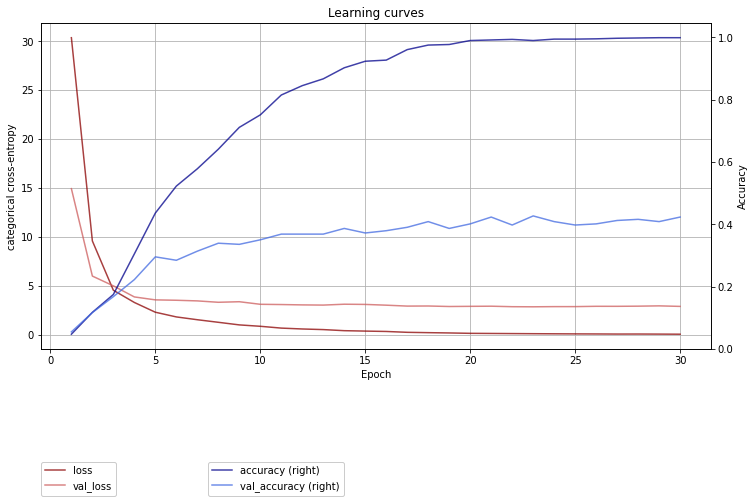

In [ ]:
df_hist1 = pd.DataFrame.from_dict(history1.history)
df_hist1["Epoch"] = np.arange(1, len(df_hist1) + 1, 1)

secondary_y = ["accuracy", "val_accuracy"] 
ax = df_hist1.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(12, 6), grid=True, legend=True,
                   ylabel="categorical cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN2 

Same as CNN1, adding MaxPooling2D with size 2x2.

In [ ]:
input_shape = batch_x_train.shape
cnn2 = Sequential([layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=25, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn2.build(input_shape)
cnn2.summary()
learning_rate = 0.001
cnn2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=['accuracy'])

epochs = 30
history2 = cnn2.fit(ds_train, epochs=epochs, validation_data=ds_val)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (64, 94, 94, 64)          1792      
                                                                 
 activation_4 (Activation)   (64, 94, 94, 64)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (64, 47, 47, 64)         0         
 )                                                               
                                                                 
 conv2d_5 (Conv2D)           (64, 45, 45, 128)         73856     
                                                                 
 activation_5 (Activation)   (64, 45, 45, 128)         0         
                                                                 
 global_max_pooling2d_2 (Glo  (64, 128)                0         
 balMaxPooling2D)                                     

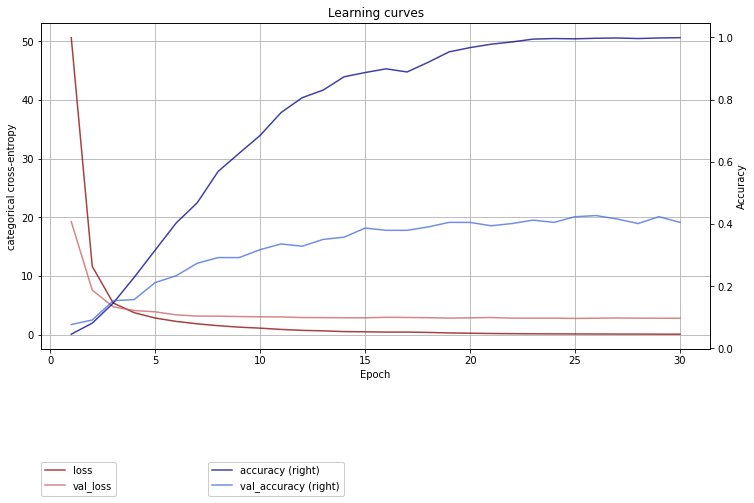

In [ ]:
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

secondary_y = ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(12, 6), grid=True, legend=True,
                   ylabel="categorical cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN3
Same mode as above, considering the rescaling of input data, with BatchNormalization layer

In [ ]:
input_shape = batch_x_train.shape
cnn3 = Sequential([layers.BatchNormalization(),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=25, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn3.build(input_shape)
cnn3.summary()
learning_rate = 0.01
cnn3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=['accuracy'])

epochs = 50
history3 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_val)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (64, 96, 96, 3)          12        
 ormalization)                                                   
                                                                 
 conv2d_6 (Conv2D)           (64, 94, 94, 64)          1792      
                                                                 
 activation_6 (Activation)   (64, 94, 94, 64)          0         
                                                                 
 max_pooling2d_1 (MaxPooling  (64, 47, 47, 64)         0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (64, 45, 45, 128)         73856     
                                                                 
 activation_7 (Activation)   (64, 45, 45, 128)        

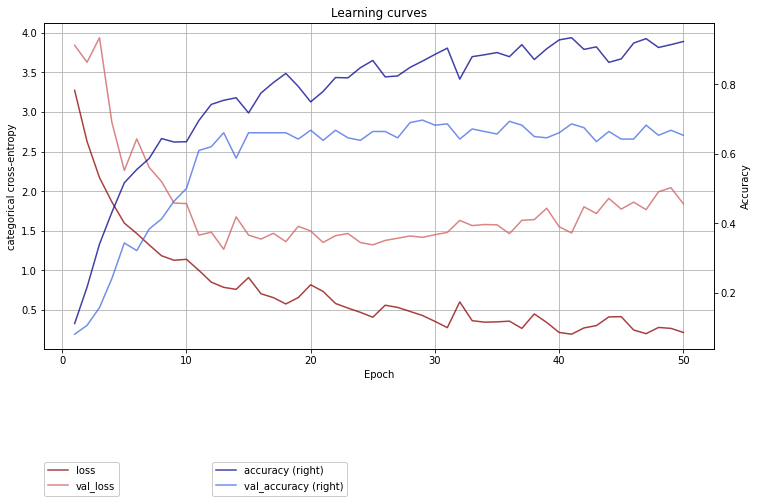

In [ ]:
df_hist = pd.DataFrame.from_dict(history3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
secondary_y = ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(12, 6), grid=True, legend=True,
                   ylabel="categorical cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN4
Adding data augmentation to the model

In [ ]:
input_shape = batch_x_train.shape
cnn4 = Sequential([augmentation,
                   layers.BatchNormalization(),
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=25, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn4.build(input_shape)
cnn4.summary()
learning_rate = 0.01
cnn4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=['accuracy'])

epochs = 50
history4 = cnn4.fit(ds_train, epochs=epochs, validation_data=ds_val)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 augmentation (Sequential)   (64, 96, 96, 3)           0         
                                                                 
 batch_normalization_1 (Batc  (64, 96, 96, 3)          12        
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (64, 94, 94, 64)          1792      
                                                                 
 activation_8 (Activation)   (64, 94, 94, 64)          0         
                                                                 
 max_pooling2d_2 (MaxPooling  (64, 47, 47, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (64, 45, 45, 128)        

18/18 [==============================] - 17s 564ms/step - loss: 3.1637 - accuracy: 0.0865 - val_loss: 6.6577 - val_accuracy: 0.0876
Epoch 2/50
18/18 [==============================] - 13s 568ms/step - loss: 2.6093 - accuracy: 0.2168 - val_loss: 4.4266 - val_accuracy: 0.1022
Epoch 3/50
18/18 [==============================] - 14s 638ms/step - loss: 2.2300 - accuracy: 0.3251 - val_loss: 4.4201 - val_accuracy: 0.1496
Epoch 4/50
18/18 [==============================] - 13s 562ms/step - loss: 1.9227 - accuracy: 0.4253 - val_loss: 3.4536 - val_accuracy: 0.2299
Epoch 5/50
18/18 [==============================] - 13s 567ms/step - loss: 1.6213 - accuracy: 0.5182 - val_loss: 4.4324 - val_accuracy: 0.2299
Epoch 6/50
18/18 [==============================] - 13s 588ms/step - loss: 1.6387 - accuracy: 0.5173 - val_loss: 2.2725 - val_accuracy: 0.4088
Epoch 7/50
18/18 [==============================] - 13s 582ms/step - loss: 1.4858 - accuracy: 0.5401 - val_loss: 2.4728 - val_accuracy: 0.3650
Epoch 8/50

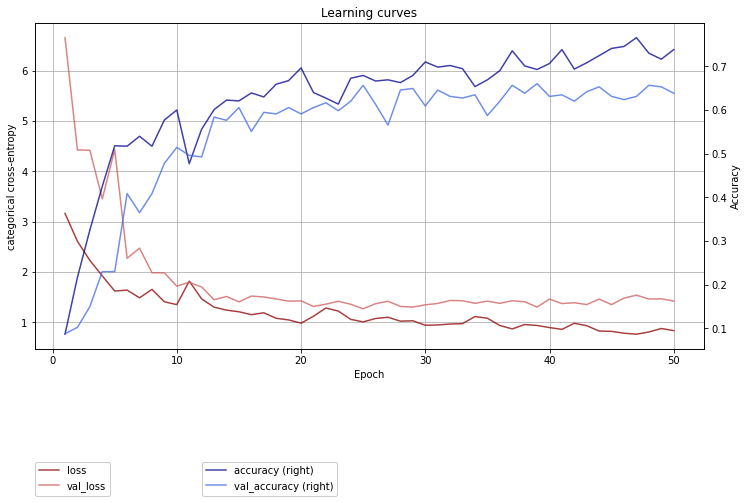

In [ ]:
df_hist = pd.DataFrame.from_dict(history4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

secondary_y = ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(12, 6), grid=True, legend=True,
                   ylabel="categorical cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

Seems to work better without augmentation

## CNN5
Dropping Augmentation, and keeping the rest of CNN4 features, add a third block:
  - conv2D with 256 filters with size 3x3, activation ReLu and maxpooling
  - also add batch normalization layers before applying the non-linearities.

In [ ]:
input_shape = tuple(batch_x_train.shape)
cnn5 = Sequential([layers.BatchNormalization(),                           
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=25, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn5.build(input_shape)
cnn5.summary() 

learning_rate = 0.01
cnn5.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy')])

epochs = 60
history5 = cnn5.fit(ds_train, epochs=epochs, validation_data=ds_val)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_2 (Batc  (64, 96, 96, 3)          12        
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (64, 94, 94, 64)          1792      
                                                                 
 batch_normalization_3 (Batc  (64, 94, 94, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_10 (Activation)  (64, 94, 94, 64)          0         
                                                                 
 max_pooling2d_3 (MaxPooling  (64, 47, 47, 64)         0         
 2D)                                                             
                                                      

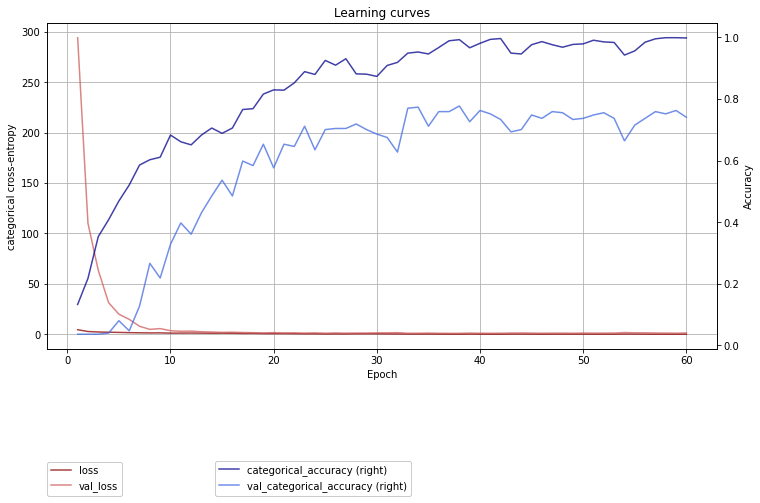

In [ ]:
df_hist = pd.DataFrame.from_dict(history5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(12, 6), grid=True, legend=True,
                   ylabel="categorical cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN6 
Equal to CNN5, adding regularization
  - we chose to use L2 regularization penalties, equal to 0.01e-3


In [ ]:
input_shape = tuple(batch_x_train.shape)
cnn6 = Sequential([layers.BatchNormalization(),                           
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-3),
                                 bias_regularizer=regularizers.L2(1e-3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-3),
                                 bias_regularizer=regularizers.L2(1e-3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-3),
                                 bias_regularizer=regularizers.L2(1e-3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.25),
                   layers.Dense(units=25, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-3),
                                bias_regularizer=regularizers.L2(1e-3),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn6.build(input_shape)
cnn6.summary() 

learning_rate = 0.01
cnn6.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy')])

epochs = 100
history6 = cnn6.fit(ds_train, epochs=epochs, validation_data=ds_val)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (64, 96, 96, 3)          12        
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (64, 94, 94, 64)          1792      
                                                                 
 batch_normalization_7 (Batc  (64, 94, 94, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_13 (Activation)  (64, 94, 94, 64)          0         
                                                                 
 max_pooling2d_5 (MaxPooling  (64, 47, 47, 64)         0         
 2D)                                                             
                                                      

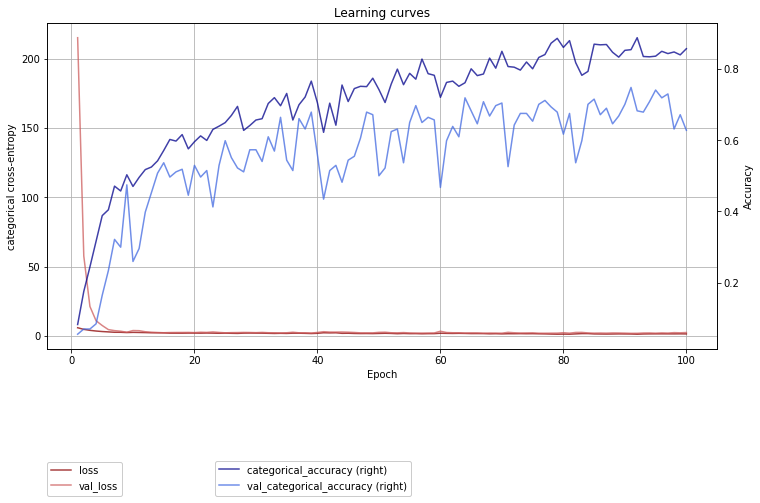

In [ ]:
df_hist = pd.DataFrame.from_dict(history6.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(12, 6), grid=True, legend=True,
                   ylabel="categorical cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN7

Equal to CNN6, adding more filters in each block

In [ ]:
input_shape = tuple(batch_x_train.shape)
cnn7 = Sequential([layers.BatchNormalization(),                           
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-3),
                                 bias_regularizer=regularizers.L2(1e-3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-3),
                                 bias_regularizer=regularizers.L2(1e-3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-3),
                                 bias_regularizer=regularizers.L2(1e-3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.25),
                   layers.Dense(units=25, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-3),
                                bias_regularizer=regularizers.L2(1e-3),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn7.build(input_shape)
cnn7.summary() 

learning_rate = 0.01
cnn7.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy')])

epochs = 100
history7 = cnn7.fit(ds_train, epochs=epochs, validation_data=ds_val)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (64, 96, 96, 3)          12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (64, 94, 94, 64)          1792      
                                                                 
 batch_normalization_1 (Batc  (64, 94, 94, 64)         256       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (64, 94, 94, 64)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (64, 47, 47, 64)         0         
 )                                                               
                                                        

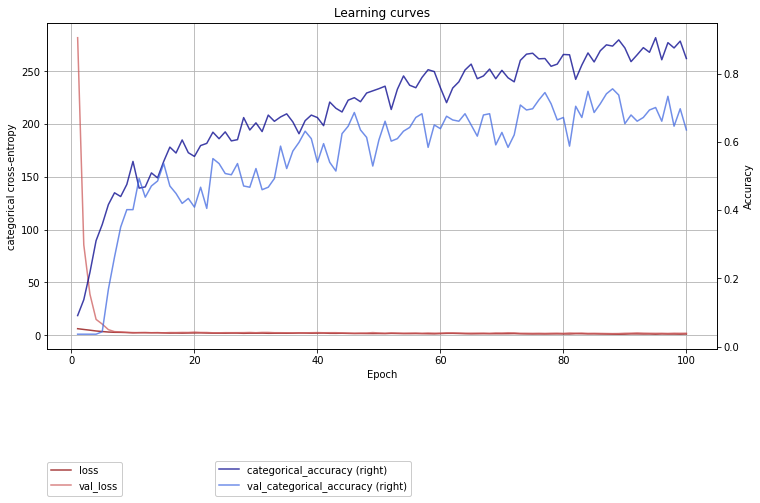

In [ ]:
df_hist = pd.DataFrame.from_dict(history7.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(12, 6), grid=True, legend=True,
                   ylabel="categorical cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN8

Same as CNN7, with even more filters per block

In [ ]:
input_shape = tuple(batch_x_train.shape)
cnn8 = Sequential([layers.BatchNormalization(),                           
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=512, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=512, kernel_size=(3, 3),
                                 kernel_regularizer=regularizers.L2(1e-4),
                                 bias_regularizer=regularizers.L2(1e-4),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dropout(0.25),
                   layers.Dense(units=25, activation="softmax",
                                kernel_regularizer=regularizers.L2(1e-4),
                                bias_regularizer=regularizers.L2(1e-4),
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn8.build(input_shape)
cnn8.summary() 

learning_rate = 0.01
cnn8.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy')])

epochs = 100
history8 = cnn8.fit(ds_train, epochs=epochs, validation_data=ds_val)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_4 (Batc  (64, 96, 96, 3)          12        
 hNormalization)                                                 
                                                                 
 conv2d_3 (Conv2D)           (64, 94, 94, 64)          1792      
                                                                 
 batch_normalization_5 (Batc  (64, 94, 94, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_3 (Activation)   (64, 94, 94, 64)          0         
                                                                 
 max_pooling2d_2 (MaxPooling  (64, 47, 47, 64)         0         
 2D)                                                             
                                                      

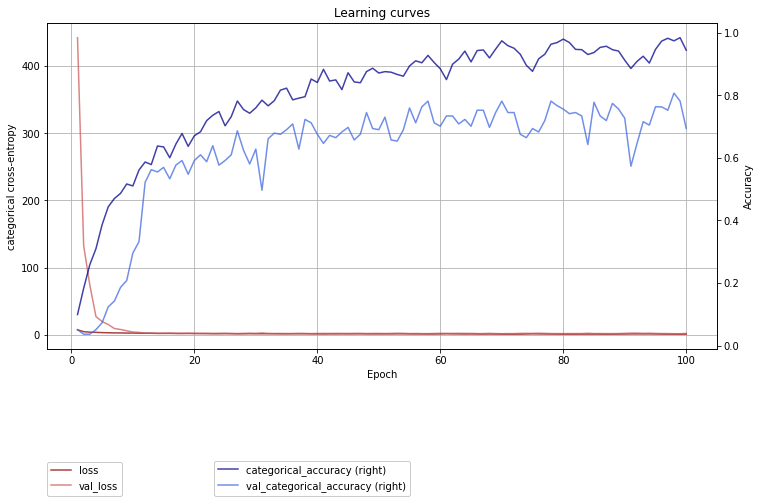

In [ ]:
df_hist = pd.DataFrame.from_dict(history8.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

secondary_y = ["categorical_accuracy", "val_categorical_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(12, 6), grid=True, legend=True,
                   ylabel="categorical cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN9
Adding more layers, fixing 4 blocks of: convolution, activation, pooling layers.
Add batch normalization layers before applying the non-linearities.

In [ ]:
input_shape = tuple(batch_x_train.shape)
cnn9 = Sequential([layers.BatchNormalization(),                           
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=512, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=25, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])
cnn9.build(input_shape)
cnn9.summary() 
learning_rate = 0.01  

cnn9.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='accuracy')])

epochs = 50
history9 = cnn9.fit(ds_train, epochs=epochs, validation_data=ds_val)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_8 (Batc  (64, 96, 96, 3)          12        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (64, 94, 94, 64)          1792      
                                                                 
 batch_normalization_9 (Batc  (64, 94, 94, 64)         256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (64, 94, 94, 64)          0         
                                                                 
 max_pooling2d_4 (MaxPooling  (64, 47, 47, 64)         0         
 2D)                                                             
                                                      

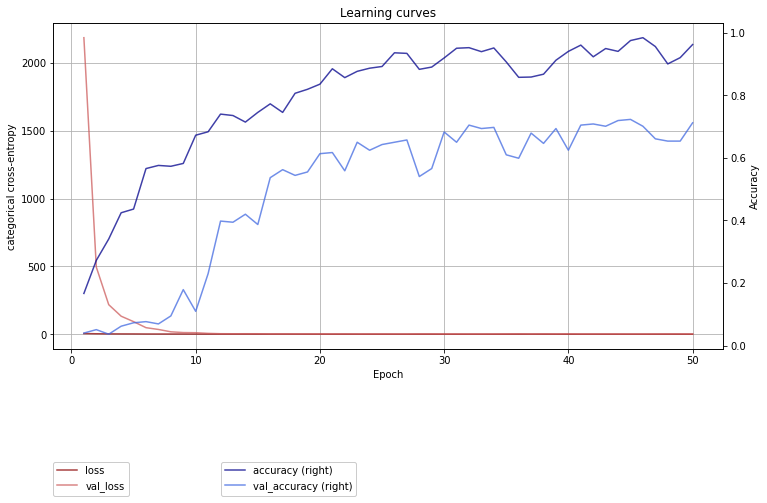

In [ ]:
df_hist = pd.DataFrame.from_dict(history9.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)

secondary_y = ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                   secondary_y = secondary_y,
                   kind="line", figsize=(12, 6), grid=True, legend=True,
                   ylabel="categorical cross-entropy", 
                   xlabel="Epoch", title="Learning curves",                  
                   color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## Re-train the model a apply it to our Testing Dataset

In [ ]:
ds_train = image_dataset_from_directory(main_folder + training_folder, 
                                        image_size=image_size,
                                        crop_to_aspect_ratio=crop_to_aspect_ratio,
                                        color_mode=color_mode,
                                        batch_size=batch_size,
                                        label_mode=label_mode,
                                        shuffle=shuffle,
                                        seed=seed)

Found 1372 files belonging to 25 classes.


### Train the final model

  - CNN_F - CNN8 (68% - 211 true 100 false) 
  - CNN_F1 - CNN7 (63% - 196 true 115 false)
  - CNN_F2 - CNN5 (74% - 228 true 83 false)

In [ ]:
input_shape = tuple(batch_x_train.shape)
cnn_f = Sequential([layers.BatchNormalization(),                           
                   layers.Conv2D(filters=64, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=128, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),                           
                   layers.Activation("relu"),                   
                   layers.GlobalMaxPooling2D(),
                   layers.Dense(units=25, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))])

cnn_f.build(input_shape)
cnn_f.summary() 

learning_rate = 0.01
cnn_f.compile(loss="CategoricalCrossentropy",
             optimizer=optimizers.Adam(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy')])

epochs = 40
historyfinal = cnn_f.fit(ds_train, epochs=epochs)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_44 (Bat  (64, 96, 96, 3)          12        
 chNormalization)                                                
                                                                 
 conv2d_33 (Conv2D)          (64, 94, 94, 64)          1792      
                                                                 
 batch_normalization_45 (Bat  (64, 94, 94, 64)         256       
 chNormalization)                                                
                                                                 
 activation_33 (Activation)  (64, 94, 94, 64)          0         
                                                                 
 max_pooling2d_22 (MaxPoolin  (64, 47, 47, 64)         0         
 g2D)                                                            
                                                     

### Apply to Test Dataset and save predictions

In [ ]:
y_pred, y_test = [], []
for batch in ds_test:    
    y_pred.append(cnn_f.predict(batch[0]))
    y_test.append(batch[1]) 

2/2 [==============================] - 0s 9ms/step


### Informação que contém o y_pred e y_test

In [ ]:
tf.math.round(tf.concat(y_pred, 0))

In [ ]:
tf.concat(y_test, 0)

In [ ]:
tf.math.equal(tf.concat(y_test, 0),tf.math.round(tf.concat(y_pred, 0)), name = None)

### Test Accuracy

In [ ]:
m = tf.keras.metrics.CategoricalAccuracy()
m.update_state(tf.math.round(tf.concat(y_pred, 0)), tf.concat(y_test, 0))
m.result().numpy()

0.7363344

### Test Precision

In [ ]:
m = tf.keras.metrics.Precision()
m.update_state(tf.math.round(tf.concat(y_pred, 0)), tf.concat(y_test, 0))
m.result().numpy()

0.72347265

### Previsões Acertadas (True Positives)

In [ ]:
m = tf.keras.metrics.TruePositives()
m.update_state(tf.math.round(tf.concat(y_pred, 0)), tf.concat(y_test, 0))
m.result().numpy()

225.0

### Previsões Erradas (False Positives)

In [ ]:
m = tf.keras.metrics.FalsePositives()
m.update_state(tf.math.round(tf.concat(y_pred, 0)), tf.concat(y_test, 0))
m.result().numpy()

86.0

## Export Requirements

In [ ]:
pip freeze > requirements.txt